## Config

In [55]:
import numpy as np
import random
import math

## Task

### Rewards

In [5]:
def create_reward_function(num_actions, means, variances):

    if len(means) != num_actions or len(variances) != num_actions:
        raise ValueError("Length of means and variances should be equal to num_actions.")

    def reward_function(action):
        action -= 1

        if action < 0 or action >= num_actions:
            raise ValueError("Invalid action index.")

        return np.random.normal(means[action], variances[action])

    return reward_function

### Policies

Random:

In [6]:
def random_bandit_policy(num_actions):
    actions = range(1, num_actions + 1)
    action = random.choice(actions)

    return action

Epsilon greedy:

In [7]:
def epsilon_greedy_policy(q_values, epsilon):
    num_actions = len(q_values)

    if np.random.rand() < epsilon:
        action = np.random.choice(num_actions)  # Explore
    else:
        action = np.argmax(q_values)  # Exploit (pick the action with the highest Q-value)

    action += 1

    return action

UCB:

In [ ]:
def ucb_policy(q_values, action_counts, total_steps, c=2):
    num_actions = len(q_values)
    ucb_values = [0] * num_actions
    
    for i in range(num_actions):
        if action_counts[i] > 0:
            exploitation = q_values[i]
            exploration = c * np.sqrt(np.log(total_steps + 1) / action_counts[i])
            ucb_values[i] = exploitation + exploration
        else:
            ucb_values[i] = float('inf')  # Force exploration if action hasn't been taken yet

    action = np.argmax(ucb_values) + 1

    return action

Thompson Sampling:

In [ ]:
def thompson_sampling_policy(action_successes, action_failures):
    num_actions = len(action_successes)
    samples = [np.random.beta(action_successes[i] + 1, action_failures[i] + 1) for i in range(num_actions)]
    
    action = np.argmax(samples) + 1

    return action

## Agent

In [251]:
class RL_Agent:
    def __init__(self, num_actions, num_agents, actions_means, actions_vars, reward_prob, policy, epsilon, beta):
        self.num_actions = num_actions
        self.num_agents = num_agents
        self.reward_prob = reward_prob

        self.actions_means = actions_means
        self.reward_function = create_reward_function(num_actions, actions_means, actions_vars)
        
        self.beta = beta  # Initial value for beta (increasing reliance on own experience)
        self.growth_rate = 0.01  # Growth rate for beta (for exponential increase)
        self.max_beta = 0.8  # Upper limit for beta
        self.max_step = 1000  # Max steps for scaling beta
        self.change_beta = (beta != 0.0) and (beta != 1.0)

        self.policy = policy
        
        self.epsilon = epsilon  # for epsilon greedy policy
        self.epsilon_decay_rate = 0.998  # Decay rate for epsilon
        self.min_epsilon = 0.05  # Minimum epsilon value

        self.q_values_own = np.zeros(num_actions) 
        self.action_counts_own = np.zeros(num_actions)

        self.q_values_social = np.zeros(num_actions)
        self.action_counts_social = np.zeros(num_actions)

        self.reward_received = False

        self.rewards = []
        self.regrets = []
        self.betas = []
        self.epsilons = []
    
    def take_action(self, step):
        if self.change_beta:
            # Increase beta over time
            self.beta = self.max_beta * np.log(1 + 0.1*step) / np.log(0.1*self.max_step)
            self.beta = min(self.beta, self.max_beta)  # Ensure beta doesn't exceed max_beta
            self.betas.append(self.beta)

        match self.policy:
            case "random bandit":
                return random_bandit_policy(self.num_actions)

            case "epsilon greedy":
                # Decay epsilon over time
                self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay_rate)
                self.epsilons.append(self.epsilon)
                
                # Balance between own and social experience
                q_values = self.beta*self.q_values_own + (1-self.beta)*self.q_values_social
                return epsilon_greedy_policy(q_values, self.epsilon)

            # case "ucb":
            #     q_values = self.beta*self.q_values_own + (1-self.beta)*self.q_values_social
            #     action = ucb_policy(q_values, self.action_counts, step)

            # case "thompson sampling": #?
            #     action = thompson_sampling_policy(self.rewards, self.num_pulls)
    
    # def receive_reward(self, action, actions):
    #     # Reward received with probability reward_prob
    #     if np.random.rand() < self.reward_prob:
    #         self.reward_received = True
            
    #         reward = self.reward_function(action)
    #         self.rewards.append(reward)
    #         return reward
        
    #     self.reward_received = False
        
    #     self.rewards.append(0) # no reward
    #     return 5*actions.count(action)/self.num_agents # between -1 and 1
    
    def receive_reward(self, action, actions):
        # Reward received with probability reward_prob
        if np.random.rand() < self.reward_prob:
            self.reward_received = True
            
            reward = self.reward_function(action)
            self.rewards.append(reward)
            return reward + 10*actions.count(action)/self.num_agents
        
        self.reward_received = True
        
        self.rewards.append(0) # no reward
        return 5*actions.count(action)/self.num_agents # between -1 and 1
    
    def update_q_values(self, action, reward):
        if not self.reward_received:
            self.action_counts_social[action-1] += 1
            self.q_values_social[action-1] += (reward - self.q_values_social[action-1]) / self.action_counts_social[action - 1]
            
            self.regrets.append(0) # no regret if no reward
            return

        self.action_counts_own[action-1] += 1
        self.q_values_own[action-1] += (reward - self.q_values_own[action-1]) / self.action_counts_own[action-1]

        # Calculate regret
        best_action = np.argmax(self.actions_means)
        best_reward = self.actions_means[best_action]
        regret = best_reward - reward
        self.regrets.append(regret)

## Run

In [172]:
def run(num_steps, agents):
    for step in range(num_steps):
        actions = [agent.take_action(step) for agent in agents]
        rewards = [agent.receive_reward(action, actions) for agent, action in zip(agents, actions)]

        for agent, action, reward in zip(agents, actions, rewards):
            agent.update_q_values(action, reward)
    
    return [agent.rewards for agent in agents], [agent.regrets for agent in agents]

In [173]:
def cumulative_reward(X):
    sum_X = []
    for i in range(len(X)):
        sum_X.append([])
        for j in range(len(X[i])):
            sum_X[i].append(sum(X[i][0:j]))
    return sum_X

In [225]:
num_actions = 5
num_agents = 10

actions_means = []
actions_vars = []
policies = []
epsilons = []

actions_means = [
    [1, 2, 3, 4, 7],
    [2, 3, 2, 5, 9],
    [3, 4, 1, 6, 8],
    [4, 5, 2, 7, 7],
    [5, 6, 3, 6, 8],
    [6, 7, 4, 5, 9],
    [7, 4, 5, 1, 8],
    [8, 3, 6, 2, 9],
    [2, 1, 7, 3, 9],
    [1, 2, 8, 4, 10]
]

actions_vars = [
    [0.1, 0.2, 0.3, 0.4, 0.7],
    [0.2, 0.3, 0.2, 0.5, 0.9],
    [0.3, 0.4, 0.1, 0.6, 0.8],
    [0.4, 0.5, 0.2, 0.7, 0.7],
    [0.5, 0.6, 0.3, 0.8, 0.6],
    [0.6, 0.7, 0.4, 0.9, 0.5],
    [0.7, 0.8, 0.5, 0.1, 0.4],
    [0.8, 0.9, 0.6, 0.2, 0.3],
    [0.9, 0.1, 0.7, 0.3, 0.2],
    [1.0, 0.2, 0.8, 0.4, 0.1]
]

policies = [
    "epsilon greedy",
    "epsilon greedy",
    "epsilon greedy",
    "random bandit",
    "random bandit",
    "random bandit",
    "epsilon greedy",
    "random bandit",
    "epsilon greedy",
    "epsilon greedy"
]

epsilons = [
    0.6,
    0.6,
    0.6,
    None,
    None,
    None,
    0.4,
    None,
    0.5,
    0.4
]

In [252]:
num_steps = 5000

agents = [
    RL_Agent(
        num_actions,
        num_agents,
        actions_means[i], 
        actions_vars[i], 
        0.3 if (i == 0) or (i == 1) or (i==2) else 1, # reward_prob
        policies[i],
        epsilons[i], 
        # 0.1 if i == 0 else 0 if i == 2 else 1, # beta
        1 if i == 0 else 0 if i == 2 else 1, # beta
    ) for i in range(num_agents)]

rewards, regrets = run(num_steps, agents)

In [253]:
c_rewards = cumulative_reward(rewards)

## Plots

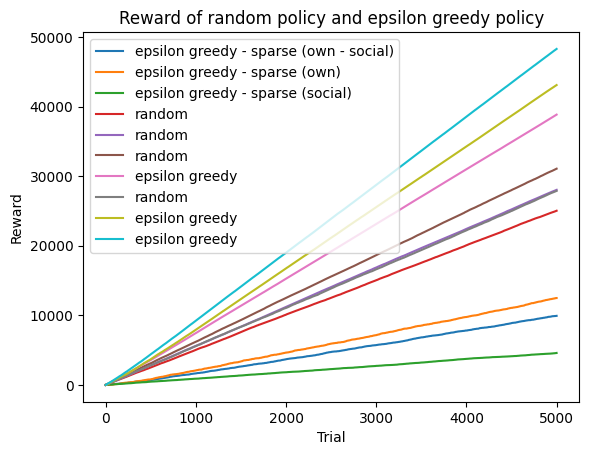

In [254]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(c_rewards[0], label="epsilon greedy - sparse (own - social)")
ax.plot(c_rewards[1], label="epsilon greedy - sparse (own)")
ax.plot(c_rewards[2], label="epsilon greedy - sparse (social)")
ax.plot(c_rewards[3], label="random")
ax.plot(c_rewards[4], label="random")
ax.plot(c_rewards[5], label="random")
ax.plot(c_rewards[6], label="epsilon greedy")
ax.plot(c_rewards[7], label="random")
ax.plot(c_rewards[8], label="epsilon greedy")
ax.plot(c_rewards[9], label="epsilon greedy")

# ax.plot(agents[0].betas, label="beta")
# ax.plot(agents[0].epsilons, label="epsilon")

# Set the title and labels
ax.set_title("Reward of random policy and epsilon greedy policy")
ax.set_xlabel("Trial")
ax.set_ylabel("Reward")
# Show the plot
plt.legend()
plt.show()